# How good is player X against CSK in Chepauk when they’re playing 3 spinners?

PART1 Player Analysis:
Player-level statistics --- (runs/sr/RPI/BPB)
Type of player --- (anchor/strike-rotator/hitter)
Performance In diff phases of play --- (PP/Middle/Death)
Performance by innings --- (Bat 1st/2nd)
PART2 Team Analysis:
Performance against oppositions --- (RPI/SR)
PART3 Venue Analysis:
Performance In venues:
Toss factor
Venue typee --- (runrates, wickets, ..)

In [5]:
import math
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

import matplotlib.pyplot as plt

In [6]:
deliveries=pd.read_csv("deliveries.csv")

In [7]:
matches = pd.read_csv("matches.csv")

In [8]:
matches.head(1)
deliveries.head(1)

,matchId,inning,over_ball,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,batsman_runs,extras,isWide,isNoBall,Byes,LegByes,Penalty,dismissal_kind,player_dismissed
0,1082591,1,0.1,0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Part 1: Player Statistics
#1.1 : Extract player-level statistics
#1.2 : Determine player type from the above stats

In [44]:
def balls_per_dismissal(balls, dismissals):
    if dismissals > 0:
        return balls/dismissals
    else:
        return balls/1 
    
def balls_per_boundary(balls, boundaries):
    if boundaries > 0:
        return balls/boundaries
    else:
        return balls/1 

def playerStatistics(df):
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [45]:
df = playerStatistics(deliveries)

In [32]:
print(df.columns)

Index(['matchId', 'inning', 'over_ball', 'over', 'ball', 'batting_team',
       'bowling_team', 'batsman', 'non_striker', 'bowler', 'batsman_runs',
       'extras', 'isWide', 'isNoBall', 'Byes', 'LegByes', 'Penalty',
       'dismissal_kind', 'player_dismissed', 'isDot', 'isOne', 'isTwo',
       'isThree', 'isFour', 'isSix'],
      dtype='object')


In [46]:
df.head()

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,23,280,196,15,61,83,20,1,16,15,142.857143,12.173913,13.066667,6.322581
1,A Badoni,11,161,139,9,57,53,11,0,11,7,115.827338,14.636364,15.444444,7.722222
2,A Chandila,2,4,7,1,3,4,0,0,0,0,57.142857,2.000000,7.000000,7.000000
3,A Chopra,6,53,75,5,45,21,2,0,7,0,70.666667,8.833333,15.000000,10.714286
4,A Choudhary,3,25,20,2,4,13,1,0,1,1,125.000000,8.333333,10.000000,10.000000


## 1.3 Performance in different phases of play

In [47]:
def phase(over):
    if over <= 6:
        return 'Powerplay'
    elif over <= 15:
        return 'Middle'
    else:
        return 'Death'

In [48]:
deliveries['phase'] = deliveries['over'].apply(lambda x: phase(x))

In [52]:
def phasesOfplay(df, current_phase):
    
    df = df[df.phase == current_phase]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [53]:
pp_df = phasesOfplay(deliveries, 'Powerplay')
mid_df = phasesOfplay(deliveries, 'Middle')
dth_df = phasesOfplay(deliveries, 'Death')

In [54]:
pp_df.head(1)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,1,5,7,1,5,1,0,0,1,0,71.428571,5.0,7.0,7.0


In [55]:
mid_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,8,83,60,3,21,23,7,0,4,5,138.333333,10.375,20.000000,6.666667
1,A Badoni,8,75,73,3,31,29,5,0,6,2,102.739726,9.375,24.333333,9.125000


In [56]:
dth_df.head(1)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,19,192,129,11,35,59,13,1,11,10,148.837209,10.105263,11.727273,6.142857


## 1.4 : Performance by Bat 1st/2nd

In [57]:
def ByInning(df, current_inning):
    
    df = df[df.inning == current_inning]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [58]:
ing1_df = ByInning(deliveries, 1)
ing2_df = ByInning(deliveries, 2)

In [59]:
ing1_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,13,166,115,7,32,53,13,1,6,10,144.347826,12.769231,16.428571,7.187500
1,A Badoni,5,106,89,5,32,38,8,0,7,4,119.101124,21.200000,17.800000,8.090909


In [60]:
ing2_df.head(2)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,10,114,81,8,29,30,7,0,10,5,140.740741,11.400000,10.125,5.400000
1,A Badoni,6,55,50,4,25,15,3,0,4,3,110.000000,9.166667,12.500,7.142857


In [61]:
comp = ing1_df[['batsman', 'RPI']].merge(ing2_df[['batsman', 'RPI']], on = 'batsman', how = 'inner').rename(columns = {'RPI_x':'1st_RPI', 'RPI_y':'2nd_RPI' })

In [62]:
comp.head()

,batsman,1st_RPI,2nd_RPI
0,A Ashish Reddy,12.769231,11.400000
1,A Badoni,21.200000,9.166667
2,A Chopra,10.200000,2.000000
3,A Choudhary,15.000000,5.000000
4,A Flintoff,22.000000,20.000000


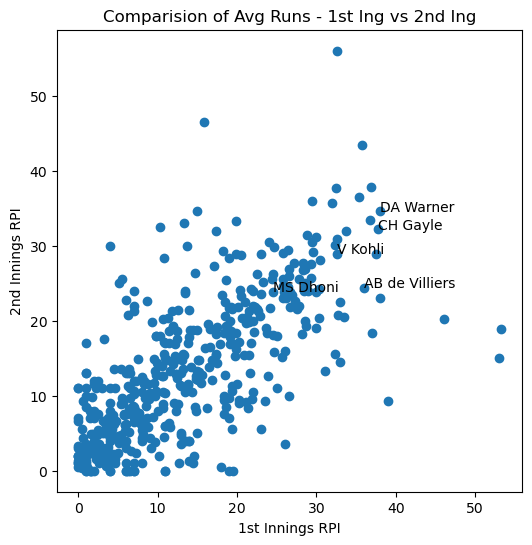

In [63]:
plt.figure(figsize = (6, 6))
plt.scatter(comp['1st_RPI'], comp['2nd_RPI'] )
plt.xlabel('1st Innings RPI')
plt.ylabel('2nd Innings RPI')
plt.title('Comparision of Avg Runs - 1st Ing vs 2nd Ing')

annotations=list(comp['batsman'])
selected_players = ['CH Gayle', 'V Kohli', 'AB de Villiers', 'DA Warner', 'MS Dhoni']

for i, label in enumerate(annotations):
    if label in selected_players:
        plt.annotate(label, (comp['1st_RPI'][i], comp['2nd_RPI'][i]))
    
    
plt.show()

## Part 2 - Performance by opposition:

In [71]:
def ByOpposition(df, current_opposition):
    
    df = df[df.bowling_team == current_opposition]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    # StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    # runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    # balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    # balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [72]:
ByOpposition(deliveries, 'Chennai Super Kings').head(3)

,batsman,innings,runs,balls,dismissals,dots,ones,twos,threes,fours,sixes,SR,RPI,BPD,BPB
0,A Ashish Reddy,3,45,25,2,8,8,2,1,3,3,180.000000,15.0,12.5,4.166667
1,A Badoni,1,19,14,0,7,3,2,0,0,2,135.714286,19.0,14.0,7.000000
2,A Kumble,2,3,6,0,4,1,1,0,0,0,50.000000,1.5,6.0,6.000000


## Part 3 : Venue Analysis

In [73]:
def wintoss_winmatch(toss_decision, team1, team2, winner):
    if toss_decision == 'field':
        if team2 == winner:
            return True
        else:
            return False
        
    else:
        if team1 == winner:
            return True
        else:
            return False

In [74]:
matches['wintoss_winmatch'] = matches.apply(lambda x: wintoss_winmatch(x['toss_decision'], x['team1'], x['team2'], x['winner']), axis = 1)

In [77]:
print('% of wintoss-winmatch =', 100*len(matches[matches.wintoss_winmatch == 1])/len(matches))

% of wintoss-winmatch = 52.73684210526316


In [102]:
def ByVenue(df, current_venue):
    
    df = df[df.venue == current_venue]
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [103]:
matches.rename(columns = {'Id':'matchId'}, inplace = True)

In [101]:
print("Columns in deliveries DataFrame:", deliveries.columns)
print("Columns in matches DataFrame:", matches.columns)

Columns in deliveries DataFrame: Index(['matchId', 'inning', 'over_ball', 'over', 'ball', 'batting_team',
       'bowling_team', 'batsman', 'non_striker', 'bowler', 'batsman_runs',
       'extras', 'isWide', 'isNoBall', 'Byes', 'LegByes', 'Penalty',
       'dismissal_kind', 'player_dismissed', 'isDot', 'isOne', 'isTwo',
       'isThree', 'isFour', 'isSix', 'phase'],
      dtype='object')
Columns in matches DataFrame: Index(['outcome', 'event', 'date', 'gender', 'reserve_umpire', 'team1',
       'toss_winner', 'umpire2', 'match_referee', 'season', 'team2',
       'winner_runs', 'balls_per_over', 'player_of_match', 'date1',
       'neutralvenue', 'venue', 'method', 'toss_decision', 'city', 'tv_umpire',
       'date2', 'winner', 'umpire1', 'match_number', 'eliminator',
       'winner_wickets', 'matchId', 'wintoss_winmatch'],
      dtype='object')


In [104]:
combined_data = deliveries.merge(matches[['matchId', 'venue']], on = 'matchId', how = 'left')

In [105]:
combined_data.head(2)

,matchId,inning,over_ball,over,ball,batting_team,bowling_team,batsman,non_striker,bowler,batsman_runs,extras,isWide,isNoBall,Byes,LegByes,Penalty,dismissal_kind,player_dismissed,isDot,isOne,isTwo,isThree,isFour,isSix,phase,venue
0,1082591,1,0.1,0,1,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,Powerplay,"Rajiv Gandhi International Stadium, Uppal"
1,1082591,1,0.2,0,2,Sunrisers Hyderabad,Royal Challengers Bangalore,DA Warner,S Dhawan,TS Mills,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,Powerplay,"Rajiv Gandhi International Stadium, Uppal"


In [106]:
current_venue = 'MA Chidambaram Stadium, Chepauk'

In [107]:
df = ByVenue(combined_data, current_venue)

In [109]:
def ByCustom(df, current_venue, current_phase, current_opposition):
    
    df = df[df.venue == current_venue]
    df = df[df.phase == current_phase]
    df = df[df.bowling_team == current_opposition]
    
    df.reset_index(inplace = True, drop = True)
    
    df['isDot'] = df['batsman_runs'].apply(lambda x: 1 if x == 0 else 0)
    df['isOne'] = df['batsman_runs'].apply(lambda x: 1 if x == 1 else 0)
    df['isTwo'] = df['batsman_runs'].apply(lambda x: 1 if x == 2 else 0)
    df['isThree'] = df['batsman_runs'].apply(lambda x: 1 if x == 3 else 0)
    df['isFour'] = df['batsman_runs'].apply(lambda x: 1 if x == 4 else 0)
    df['isSix'] = df['batsman_runs'].apply(lambda x: 1 if x == 6 else 0)
    
    runs = pd.DataFrame(df.groupby(['batsman', 'matchId'])['batsman_runs'].sum().reset_index()).groupby(['batsman'])['batsman_runs'].sum().reset_index().rename(columns={'batsman_runs':'runs'})
    innings = pd.DataFrame(df.groupby(['batsman'])['matchId'].apply(lambda x: len(list(np.unique(x)))).reset_index()).rename(columns = {'matchId':'innings'})
    balls = pd.DataFrame(df.groupby(['batsman'])['matchId'].count()).reset_index().rename(columns = {'matchId':'balls'})
    dismissals = pd.DataFrame(df.groupby(['batsman'])['player_dismissed'].count()).reset_index().rename(columns = {'player_dismissed':'dismissals'})
    
    dots = pd.DataFrame(df.groupby(['batsman'])['isDot'].sum()).reset_index().rename(columns = {'isDot':'dots'})
    ones = pd.DataFrame(df.groupby(['batsman'])['isOne'].sum()).reset_index().rename(columns = {'isOne':'ones'})
    twos = pd.DataFrame(df.groupby(['batsman'])['isTwo'].sum()).reset_index().rename(columns = {'isTwo':'twos'})
    threes = pd.DataFrame(df.groupby(['batsman'])['isThree'].sum()).reset_index().rename(columns = {'isThree':'threes'})
    fours = pd.DataFrame(df.groupby(['batsman'])['isFour'].sum()).reset_index().rename(columns = {'isFour':'fours'})
    sixes = pd.DataFrame(df.groupby(['batsman'])['isSix'].sum()).reset_index().rename(columns = {'isSix':'sixes'})
    
    df = pd.merge(innings, runs, on = 'batsman').merge(balls, on = 'batsman').merge(dismissals, on = 'batsman').merge(dots, on = 'batsman').merge(ones, on = 'batsman').merge(twos, on = 'batsman').merge(threes, on = 'batsman').merge(fours, on = 'batsman').merge(sixes, on = 'batsman')
    
    #StrikeRate
    df['SR'] = df.apply(lambda x: 100*(x['runs']/x['balls']), axis = 1)

    #runs per innings
    df['RPI'] = df.apply(lambda x: x['runs']/x['innings'], axis = 1)

    #balls per dismissals
    df['BPD'] = df.apply(lambda x: balls_per_dismissal(x['balls'], x['dismissals']), axis = 1)

    #balls per boundary
    df['BPB'] = df.apply(lambda x: balls_per_boundary(x['balls'], (x['fours'] + x['sixes'])), axis = 1)
    
    return df

In [110]:
df = ByCustom(combined_data, 'MA Chidambaram Stadium, Chepauk', 'Middle', 'Chennai Super Kings')

In [111]:
df['dot_percentage'] = df.apply(lambda x: x['dots']/x['balls'], axis = 1)

In [112]:
wt_sr, wt_rpi, wt_bpd, wt_dot_percentage = 0.13, 0.27, 0.16, 0.45

In [113]:
df = df[df.innings >= 2 ]

## Calculation - Normalizing all values to same dimensions

In [116]:
#step1: square of all values
df['calc_SR'] = df['SR'].apply(lambda x: x*x) 
df['calc_RPI'] = df['RPI'].apply(lambda x: x*x) 
df['calc_BPD'] = df['BPD'].apply(lambda x: x*x) 
df['calc_dot_percentage'] = df['dot_percentage'].apply(lambda x: x*x)

sq_sr, sq_rpi, sq_bpd, sq_dot_percentage = np.sqrt(df[['calc_SR','calc_RPI', 'calc_BPD', 'calc_dot_percentage']].sum(axis = 0))

df['calc_SR'] = df['calc_SR'].apply(lambda x: x/sq_sr) 
df['calc_RPI'] = df['calc_RPI'].apply(lambda x: x/sq_rpi) 
df['calc_BPD'] = df['calc_BPD'].apply(lambda x: x/sq_bpd) 
df['calc_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: x/sq_dot_percentage)

df['calc_SR'] = df['calc_SR'].apply(lambda x: x*wt_sr) 
df['calc_RPI'] = df['calc_RPI'].apply(lambda x: x*wt_rpi) 
df['calc_BPD'] = df['calc_BPD'].apply(lambda x: x*wt_bpd) 
df['calc_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: x*wt_dot_percentage)

best_sr, worst_sr = max(df['calc_SR']), min(df['calc_SR'])
best_rpi, worst_rpi = max(df['calc_RPI']), min(df['calc_RPI'])
best_bpd, worst_bpd = max(df['calc_BPD']), min(df['calc_BPD'])
best_dot_percentage, worst_dot_percentage = min(df['calc_dot_percentage']), max(df['calc_dot_percentage'])

In [ ]:
#Calculation - Comparision against the best & worst values

In [117]:
df['dev_best_SR'] = df['calc_SR'].apply(lambda x: (x-best_sr)*(x-best_sr)) 
df['dev_best_RPI'] = df['calc_RPI'].apply(lambda x: (x-best_rpi)*(x-best_rpi)) 
df['dev_best_BPD'] = df['calc_BPD'].apply(lambda x: (x-best_bpd)*(x-best_bpd)) 
df['dev_best_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: (x-best_dot_percentage)*(x-best_dot_percentage))

df['dev_best_sqrt'] = df.apply(lambda x: x['dev_best_SR'] + x['dev_best_RPI'] + x['dev_best_BPD'] + x['dev_best_dot_percentage'], axis = 1) 

df['dev_worst_SR'] = df['calc_SR'].apply(lambda x: (x-worst_sr)*(x-worst_sr)) 
df['dev_worst_RPI'] = df['calc_RPI'].apply(lambda x: (x-worst_rpi)*(x-worst_rpi)) 
df['dev_worst_BPD'] = df['calc_BPD'].apply(lambda x: (x-worst_bpd)*(x-worst_bpd)) 
df['dev_worst_dot_percentage'] = df['calc_dot_percentage'].apply(lambda x: (x-worst_dot_percentage)*(x-worst_dot_percentage))

df['dev_worst_sqrt'] = df.apply(lambda x: x['dev_worst_SR'] + x['dev_worst_RPI'] + x['dev_worst_BPD'] + x['dev_worst_dot_percentage'], axis = 1) 

## Final Step - Overall score for each player ( values from 0 - 1)

In [119]:
df['score'] = df.apply(lambda x: x['dev_worst_sqrt']/(x['dev_worst_sqrt'] + x['dev_best_sqrt']), axis = 1)

In [121]:
df[['batsman', 'score']].head(7)

,batsman,score
5,AB de Villiers,0.861171
7,AD Mathews,0.333700
8,AD Russell,0.248504
10,AL Menaria,0.026945
14,AT Rayudu,0.010286
25,CL White,0.149187
27,DA Miller,0.215640


# End Result: Top players for our required role against CSK in chepauk

In [124]:
df[[ 'batsman','innings', 'runs', 'balls', 'dismissals', 'dot_percentage', 'score']].sort_values(['score'], ascending = False).reset_index(drop = True).head(5)

,batsman,innings,runs,balls,dismissals,dot_percentage,score
0,SE Marsh,3,93,50,1,0.240000,0.900001
1,AB de Villiers,3,99,67,0,0.253731,0.861171
2,G Gambhir,3,80,72,1,0.319444,0.600714
3,SR Watson,4,105,66,3,0.287879,0.532521
4,NV Ojha,3,67,41,2,0.292683,0.530910


## They are the Top 5 players who are good against CSK in Chepauk when they’re playing 3 spinners 